### Import TensorFlow

Reference - https://keras.io/api/applications/efficientnet_v2/

In [ ]:
import numpy as np
import zipfile
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
import pathlib
dataset_url = "file:///content/FMD_extended.zip"

archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)

144810508/144810508 [==============================] - 1s 0us/step


In [ ]:
archive

'/root/.keras/datasets/FMD_extended.zip'

In [ ]:
os.path.getsize(archive)

144810508

In [ ]:
with zipfile.ZipFile(archive,"r") as zip_ref:
    zip_ref.extractall("targetdir")

In [ ]:

data_dir = pathlib.Path('/content/targetdir/FMD_extended/')

In [ ]:
data_dir

PosixPath('/content/targetdir/FMD_extended')

In [ ]:
os.path.getsize(data_dir)

4096

In [ ]:
for item in data_dir.glob("*"):
  print(item.name)

image
mask


In [ ]:
image_count = len(list(data_dir.glob('image/fabric/*.jpg')))
print(image_count)

146


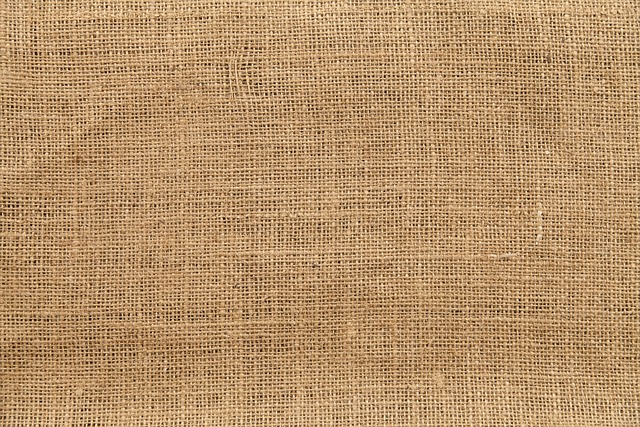

In [ ]:
fabric = list(data_dir.glob('image/fabric/*'))
PIL.Image.open(str(fabric[0]))

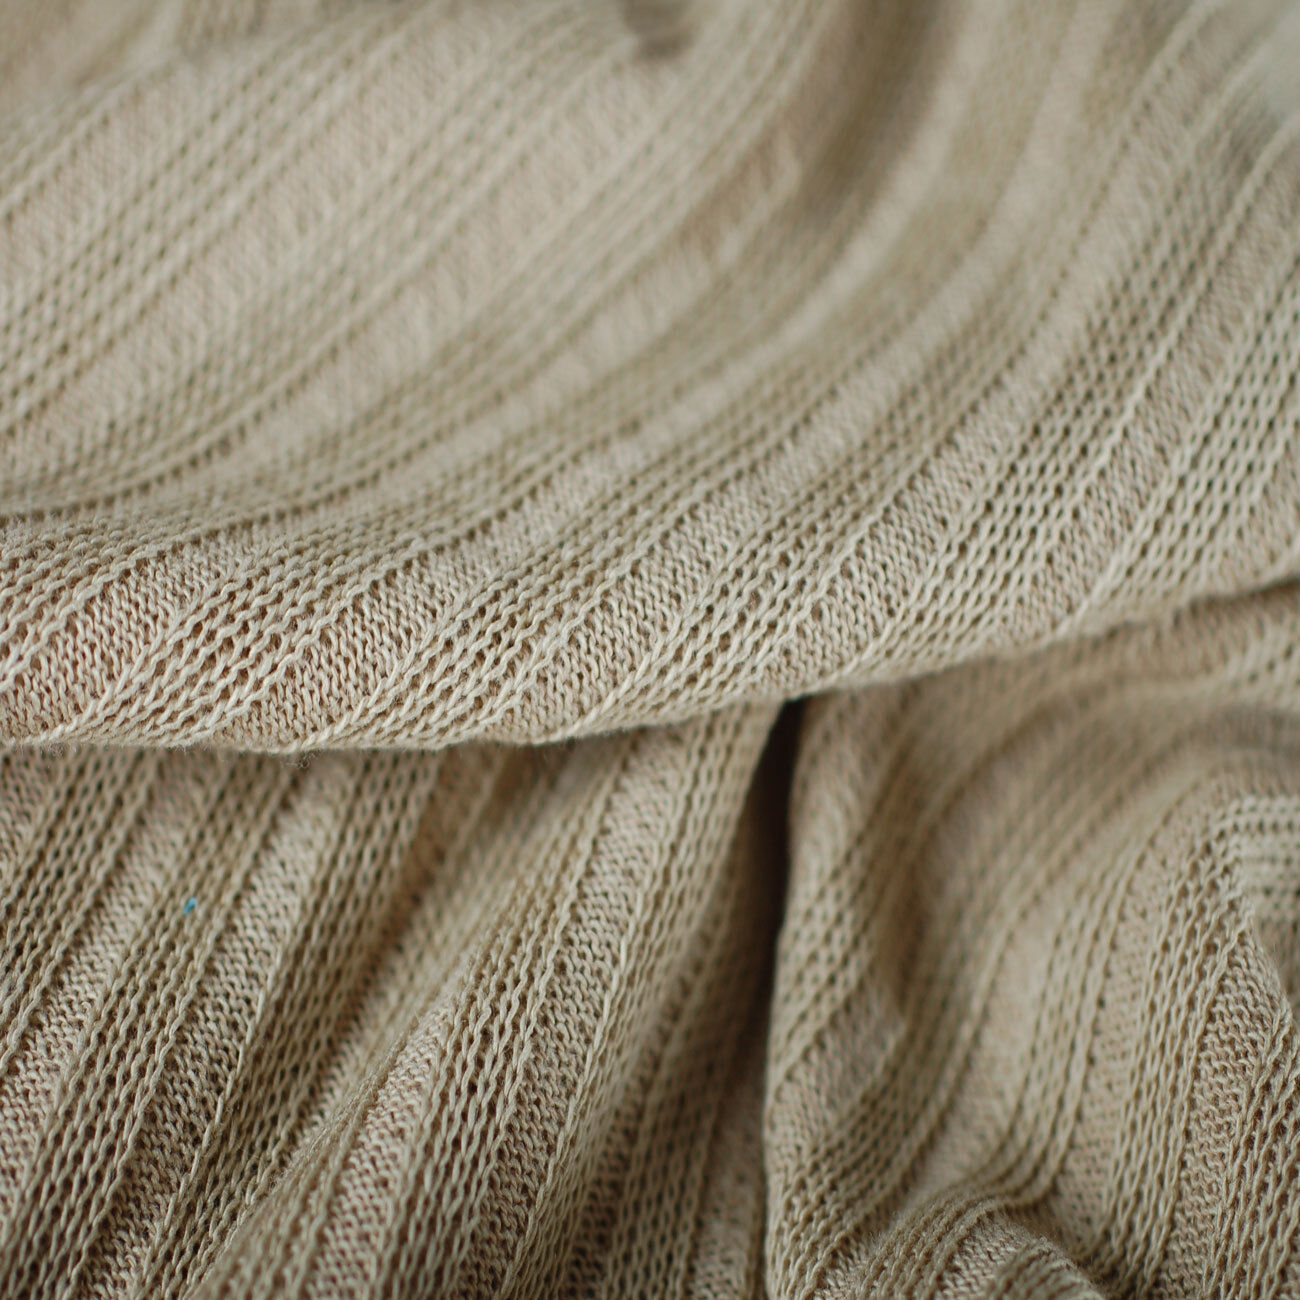

In [ ]:
PIL.Image.open(str(fabric[1]))

In [ ]:
batch_size = 32
img_height = 380
img_width = 380

In [ ]:
images = data_dir / 'image'
images

PosixPath('/content/targetdir/FMD_extended/image')

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  images,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 1474 files belonging to 10 classes.
Using 1106 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  images,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size= 1
  )

Found 1474 files belonging to 10 classes.
Using 368 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
num_classes=len(class_names)

['cardboard', 'fabric', 'food', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'wood']


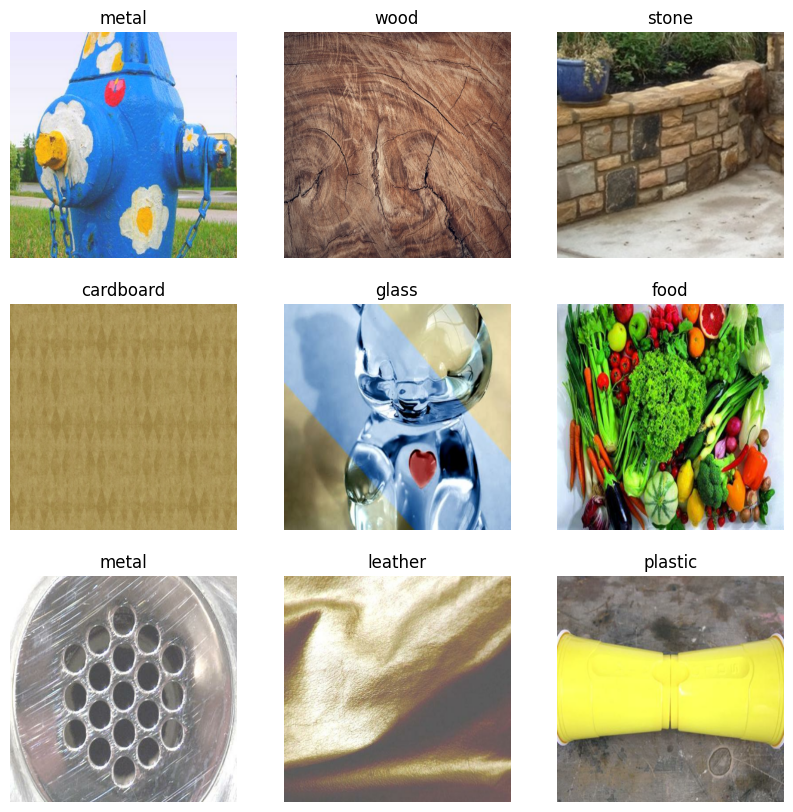

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_layer = tf.keras.layers.Input(shape=(img_height, img_width, 3), name="input_image")

rotation_layer = layers.RandomRotation(factor=0.15)(input_layer)
translation_layer = layers.RandomTranslation(height_factor=0.1, width_factor=0.1)(rotation_layer)
flip_layer = layers.RandomFlip()(translation_layer)
contrast_layer = layers.RandomContrast(factor=0.1)(flip_layer)

img_augmentation = tf.keras.Model(inputs=input_layer, outputs=contrast_layer, name="img_augmentation")

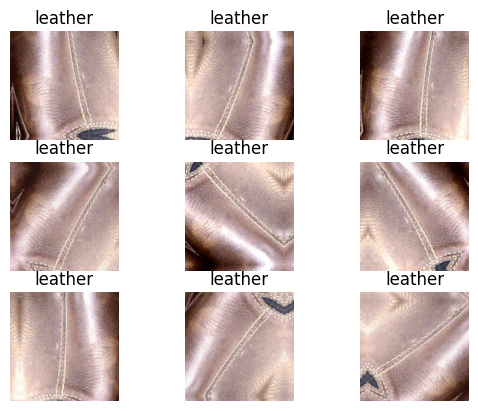

In [ ]:
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(class_names[label[0]]))
        plt.axis("off")

In [ ]:
train_ds = train_ds.shuffle(buffer_size=200)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
import math

def lr_decay(epoch):
  return 0.01 * math.pow(0.6,epoch)

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(img_height, img_width, 3))

    rotation_layer = layers.RandomRotation(factor=0.15)(inputs)
    translation_layer = layers.RandomTranslation(height_factor=0.1, width_factor=0.1)(rotation_layer)
    flip_layer = layers.RandomFlip()(translation_layer)
    contrast_layer = layers.RandomContrast(factor=0.1)(flip_layer)

    model = EfficientNetV2B0(include_top=False, input_tensor=contrast_layer, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNetV2B0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer = optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model(num_classes=num_classes)

24274472/24274472 [==============================] - 1s 0us/step


Epoch 1/30
35/35 - 33s - loss: 2.3879 - accuracy: 0.3074 - val_loss: 1.4074 - val_accuracy: 0.6630 - 33s/epoch - 932ms/step
Epoch 2/30
35/35 - 13s - loss: 1.3586 - accuracy: 0.5678 - val_loss: 1.0378 - val_accuracy: 0.7527 - 13s/epoch - 383ms/step
Epoch 3/30
35/35 - 12s - loss: 1.0009 - accuracy: 0.6564 - val_loss: 0.8213 - val_accuracy: 0.8125 - 12s/epoch - 352ms/step
Epoch 4/30
35/35 - 17s - loss: 0.8514 - accuracy: 0.7278 - val_loss: 0.6953 - val_accuracy: 0.8288 - 17s/epoch - 478ms/step
Epoch 5/30
35/35 - 13s - loss: 0.7960 - accuracy: 0.7459 - val_loss: 0.6261 - val_accuracy: 0.8315 - 13s/epoch - 360ms/step
Epoch 6/30
35/35 - 12s - loss: 0.7022 - accuracy: 0.7694 - val_loss: 0.5682 - val_accuracy: 0.8451 - 12s/epoch - 355ms/step
Epoch 7/30
35/35 - 12s - loss: 0.6904 - accuracy: 0.7722 - val_loss: 0.5288 - val_accuracy: 0.8478 - 12s/epoch - 329ms/step
Epoch 8/30
35/35 - 12s - loss: 0.6382 - accuracy: 0.7812 - val_loss: 0.5163 - val_accuracy: 0.8478 - 12s/epoch - 347ms/step
Epoch 9/

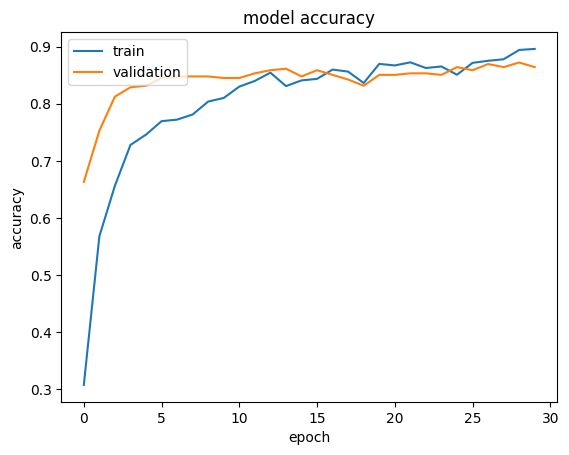

In [ ]:
epochs = 30
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

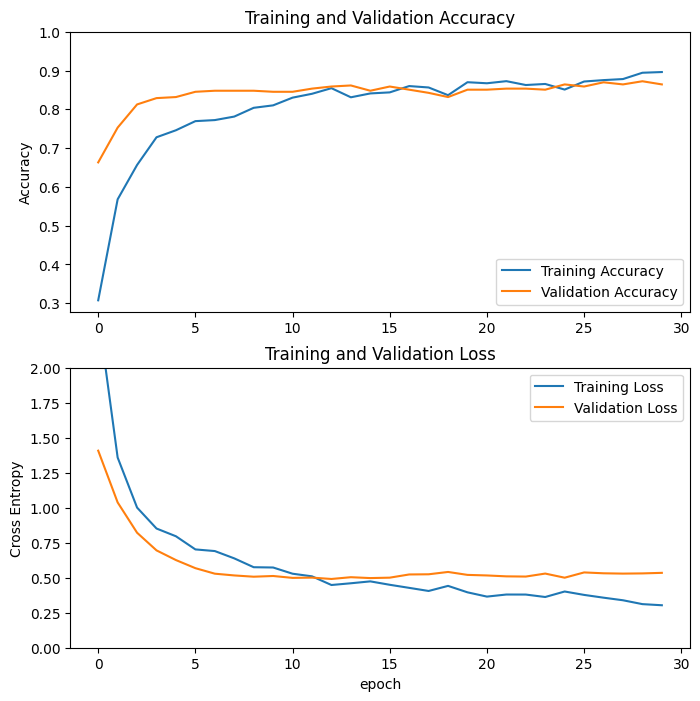

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Epoch 30: LearningRateScheduler setting learning rate to 3.6845653286788853e-09.
Epoch 30/45
35/35 [==============================] - 25s 259ms/step - loss: 0.3198 - accuracy: 0.8906 - sparse_top_k_categorical_accuracy: 0.9991 - val_loss: 0.5352 - val_accuracy: 0.8668 - val_sparse_top_k_categorical_accuracy: 0.9891 - lr: 3.6846e-09

Epoch 31: LearningRateScheduler setting learning rate to 2.210739197207331e-09.
Epoch 31/45
35/35 [==============================] - 14s 225ms/step - loss: 0.2900 - accuracy: 0.9014 - sparse_top_k_categorical_accuracy: 0.9964 - val_loss: 0.5352 - val_accuracy: 0.8668 - val_sparse_top_k_categorical_accuracy: 0.9891 - lr: 2.2107e-09

Epoch 32: LearningRateScheduler setting learning rate to 1.3264435183243988e-09.
Epoch 32/45
35/35 [==============================] - 14s 230ms/step - loss: 0.3018 - accuracy: 0.8942 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.5351 - val_accuracy: 0.8668 - val_sparse_top_k_categorical_accuracy: 0.9891 - lr: 1.3264e

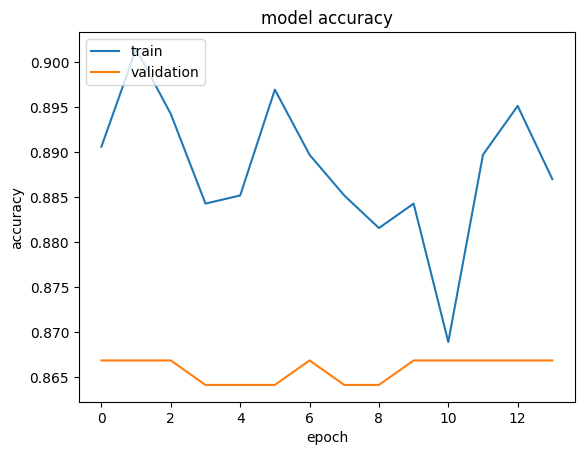

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 40 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-40:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
    model.compile(
        optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy","sparse_top_k_categorical_accuracy"]
    )

unfreeze_model(model)

fine_tune_epochs = 15
total_epochs = epochs + fine_tune_epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)   #early stopping given since it was causing overfitting.
history_fine_early = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=hist.epoch[-1],
                         validation_data=val_ds,
                         callbacks =[lr_decay_callback, early_stop])
plot_hist(history_fine_early)

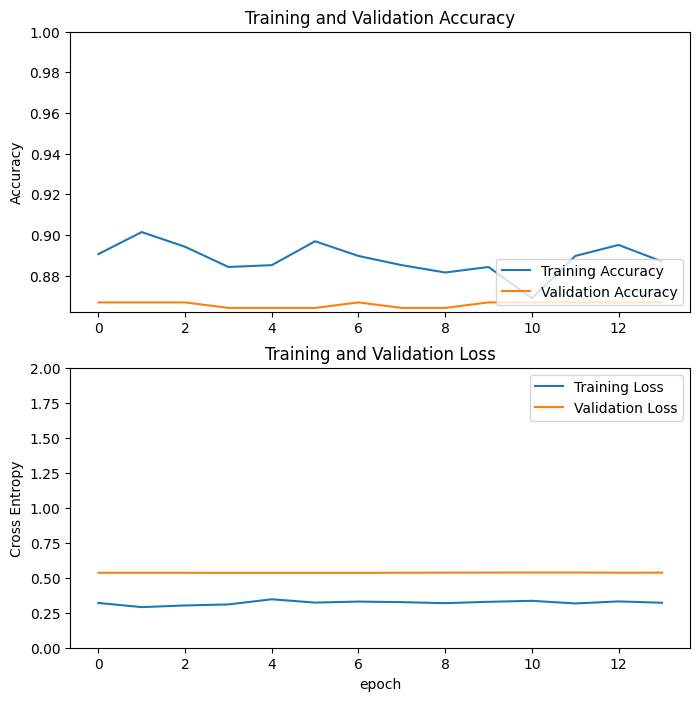

In [ ]:
acc = history_fine_early.history['accuracy']
val_acc = history_fine_early.history['val_accuracy']

loss = history_fine_early.history['loss']
val_loss = history_fine_early.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
_, accuracy,_  = model.evaluate(val_ds)
print("Test accuracy:" , accuracy)

368/368 [==============================] - 8s 20ms/step - loss: 0.5362 - accuracy: 0.8668 - sparse_top_k_categorical_accuracy: 0.9891
Test accuracy: 0.866847813129425


In [ ]:
for image, label in val_ds.take(1):
  predictions = model.predict(image)
  print(np.argmax(predictions, axis=1))
  print(label.numpy())
  print(class_names[label.numpy()[0]])


1/1 [==============================] - 2s 2s/step
[4]
[4]
leather


In [ ]:
model.save("effnetV2B0_86_.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

baseline_tflite = "unquantized.tflite"
with open(baseline_tflite, 'wb') as f:
  f.write(tflite_model)
print("Size of the unquantized tflite model: %.2f Mb" % (os.path.getsize(baseline_tflite)/float(2**20)))

Size of the unquantized tflite model: 22.37 Mb


In [ ]:
model.summary()

Model: "EfficientNetV2B0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 380, 380, 3)]        0         []                            
                                                                                                  
 random_rotation_1 (RandomR  (None, 380, 380, 3)          0         ['input_1[0][0]']             
 otation)                                                                                         
                                                                                                  
 random_translation_1 (Rand  (None, 380, 380, 3)          0         ['random_rotation_1[0][0]']   
 omTranslation)                                                                                   
                                                                                   

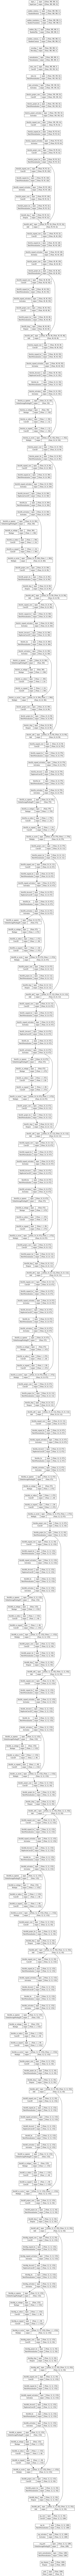

In [ ]:
dot_img_file = '/tmp/efficientnet0.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, )